# Lab 4: Kernel Regression
Covered Topics:
> Nadaraya-Watson Estimator

> Kernel Ridge Regression

> SGD for Kernel Ridge Regression

> Block Coordinate Descent (BCD) for Kernel Ridge Regression

# Motivation
> Implement some typical kernel functions, and check their feasibility in different models. You may find that some kernels work better for some models while perform poorly for the other models

> Implement classic kernel methods like Nadaraya-Watson estimator and kernel ridge regression (KRR). Observe their differences and connections.

> Take KRR as a good example. Try to sharpen your hyperparameter fine-tuning feelings.

# Data Simulator and Testing Function (Don't change them)

In [2]:
import copy
import numpy as np
import matplotlib.pyplot as plt
# don't add any other packages

def polynomial_data_simulator(n_train: int = 50,
                              n_test: int = 10,
                              order: int = 5,
                              v_noise: float = 1,
                              r_seed: int = 42) -> dict:
    """
    Simulate the training and testing data generated by a polynomial model
    :param n_train: the number of training data
    :param n_test: the number of testing data
    :param order: the order of the polynomial function
    :param v_noise: the variance of noise
    :param r_seed: the random seed
    :return:
        a dictionary containing training set, testing set, and the ground truth parameters
    """
    x_train = 4 * (np.random.RandomState(r_seed).rand(n_train) - 0.5)
    X_train = np.array([x_train ** d for d in range(order)]).T
    x_test = 5 * (np.random.RandomState(r_seed).rand(n_test) - 0.5)
    X_test = np.array([x_test ** d for d in range(order)]).T
    weights = np.random.RandomState(r_seed).randn(order, 1)
    y_train = X_train @ weights + v_noise * \
        np.random.RandomState(r_seed).randn(n_train, 1)
    y_test = X_test @ weights + v_noise * \
        np.random.RandomState(r_seed).randn(n_test, 1)
    data = {'train': [np.expand_dims(x_train, axis=1), y_train],
            'test': [np.expand_dims(x_test, axis=1), y_test],
            'real': weights}
    return data


def visualization_curves(weights: np.ndarray, label: str, curve_type: str):
    landmarks = 5 * (np.arange(0, 100) / 100 - 0.5)
    order = weights.shape[0]
    curve = np.array([landmarks ** d for d in range(order)]).T @ weights
    plt.plot(landmarks, curve, curve_type, label=label)


def visualization_points(x: np.ndarray, y: np.ndarray, label: str, point_type: str):
    plt.plot(x, y, point_type, label=label)


def visualization_kernel_curves(alpha: np.ndarray, x_train: np.ndarray,
                                k_type: str, h: float, label: str, curve_type: str, normalize: bool = False):
    landmarks = 5 * (np.arange(0, 100) / 100 - 0.5)
    kappa = kernel(x=x_train, y=np.expand_dims(
        landmarks, axis=1), k_type=k_type, bandwidth=h)
    if normalize:
        curve = (kappa / np.sum(kappa + 1e-10, axis=1, keepdims=True)) @ alpha
    else:
        curve = kappa @ alpha
    plt.plot(landmarks, curve, curve_type, label=label)


def mse(x: np.ndarray, x_est: np.ndarray) -> float:
    return np.sum((x - x_est) ** 2) / x.shape[0]

# Task 1
Implement the following four kinds of kernel functions and use them to achieve the Nadaraya-Watson estimator shown in the lecture.
> RBF: $K_h(\boldsymbol{x}, \boldsymbol{x'}) = \exp(-\dfrac{\|\boldsymbol{x} - \boldsymbol{x'}\|_2^2}{h})$

> Gate: $K_h(\boldsymbol{x}, \boldsymbol{x'}) = \dfrac{1}{h}\cdot \mathbb{I}(\|\boldsymbol{x} - \boldsymbol{x'}\|_1 \leq h)$

> Triangle: $K_h(\boldsymbol{x}, \boldsymbol{x'}) = \dfrac{2}{h}\cdot (1 - \dfrac{\|\boldsymbol{x} - \boldsymbol{x'}\|_1}{h})\cdot \mathbb{I}(\|\boldsymbol{x} - \boldsymbol{x'}\|_1 \leq h)$

> Linear: $K(\boldsymbol{x}, \boldsymbol{x'}) = \boldsymbol{x}^T\boldsymbol{x'}$

where $h$ is the hyperparameter. The NW estimator is
$$
y_{new} = \dfrac{\sum_{i=1}^N K_h(\boldsymbol{x}_{new}, \boldsymbol{x}_i)y_i}{\sum_{i=1}^N K_h(\boldsymbol{x}_{new}, \boldsymbol{x}_i)}
$$

## Solution 1
First, we implement `p_distance` to calculate the distance between two points (p-norm) to simply further coding. We are given two dataset
$$
\boldsymbol{X} = \begin{bmatrix}
\boldsymbol{x_1}^\top\\
\boldsymbol{x_2}^\top\\
\vdots\\
\boldsymbol{x_N}^\top
\end{bmatrix}\in \mathbb{R}^{N\times D},\boldsymbol{Y} = \begin{bmatrix}
\boldsymbol{y_1}^\top\\
\boldsymbol{y_2}^\top\\
\vdots\\
\boldsymbol{y_M}^\top
\end{bmatrix}\in \mathbb{R}^{M\times D}
$$
Denote the LP distance between each row vector $\boldsymbol{x_i}^\top$ and $\boldsymbol{y_j}^\top$ as $d(\boldsymbol{x_i}, \boldsymbol{y_j})=|\boldsymbol{x_i}-\boldsymbol{y_j}|^p$. Then we can calculate the LP distance matrix $\boldsymbol{D}\in \mathbb{R}^{N\times M}$ as
$$
\boldsymbol{D}= \begin{bmatrix}
d(\boldsymbol{x_1}, \boldsymbol{y_1}) & d(\boldsymbol{x_1}, \boldsymbol{y_2}) & \cdots & d(\boldsymbol{x_1}, \boldsymbol{y_M})\\
d(\boldsymbol{x_2}, \boldsymbol{y_1}) & d(\boldsymbol{x_2}, \boldsymbol{y_2}) & \cdots & d(\boldsymbol{x_2}, \boldsymbol{y_M})\\
\vdots & \vdots & \ddots & \vdots\\
d(\boldsymbol{x_N}, \boldsymbol{y_1}) & d(\boldsymbol{x_N}, \boldsymbol{y_2}) & \cdots & d(\boldsymbol{x_N}, \boldsymbol{y_M})
\end{bmatrix}\in \mathbb{R}^{N\times M}
$$
The magic way we achieve this is by using the broadcasting mechanism in numpy.
> We use `np.expand_dims` to expand the dimension of $\boldsymbol{X}_{(N\times D)}$ and $\boldsymbol{Y}_{(M\times D)}$ to $\boldsymbol{X}_{(N\times 1\times D)}$ and $\boldsymbol{Y}_{(1\times M\times D)}$ respectively. Then we can calculate the LP distance matrix $\boldsymbol{D}$ by `np.sum` along the last dimension.









In [19]:
x = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
y = np.array([[1,2,3,4],[5,6,7,8]])
x_expand = np.expand_dims(x, axis=1)
y_expand = np.expand_dims(y, axis=0)
x_expand, x.shape, x_expand.shape

(array([[[ 1,  2,  3,  4]],
 
        [[ 5,  6,  7,  8]],
 
        [[ 9, 10, 11, 12]]]),
 (3, 4),
 (3, 1, 4))

In [20]:
y_expand, y.shape, y_expand.shape

(array([[[1, 2, 3, 4],
         [5, 6, 7, 8]]]),
 (2, 4),
 (1, 2, 4))

In [21]:
(x_expand-y_expand), (x_expand-y_expand).shape

(array([[[ 0,  0,  0,  0],
         [-4, -4, -4, -4]],
 
        [[ 4,  4,  4,  4],
         [ 0,  0,  0,  0]],
 
        [[ 8,  8,  8,  8],
         [ 4,  4,  4,  4]]]),
 (3, 2, 4))

In [6]:
np.abs(x_expand-y_expand)

array([[[0, 0, 0, 0],
        [4, 4, 4, 4]],

       [[4, 4, 4, 4],
        [0, 0, 0, 0]],

       [[8, 8, 8, 8],
        [4, 4, 4, 4]]])

In [7]:
p=1
distance_matrix = np.sum(np.abs(x_expand-y_expand)**p, axis=2)
distance_matrix, distance_matrix.shape

(array([[ 0, 16],
        [16,  0],
        [32, 16]]),
 (3, 2))

In [8]:
def p_distance(x: np.ndarray, y: np.ndarray, p: int = 2) -> float:
    return np.sum(np.abs(np.expand_dims(x, axis=1)-np.expand_dims(y, axis=0))**p, axis=2)

p_distance(x, y, 1)

array([[ 0, 16],
       [16,  0],
       [32, 16]])

Then, we implement `kernel` with four kernel functions.

In [9]:
def kernel(x: np.ndarray, y: np.ndarray = None, k_type: str = 'rbf', bandwidth: float = 'h') -> np.ndarray:
    """
    Implement four kinds of typical kernel functions
    1) RBF kernel: k(x, y) = exp(-||x - y||_2^2 / bandwidth)
    2) 'Gate' kernel: k(x, y) = 1/bandwidth if ||x - y||_1 <= bandwidth, = 0 otherwise
    3) 'Triangle' kernel: k(x, y) = (bandwidth - ||x - y||_1) if ||x - y||_1 <= bandwidth, = 0 otherwise
    4) Linear kernel: k(x, y) = <x, y>
    :param x: a set of samples with size (N, D), where N is the number of samples, D is the dimension of features
    :param y: a set of samples with size (M, D), where M is the number of samples. this input can be None
    :param k_type: the type of kernels, including 'rbf', 'gate', 'triangle', 'linear'
    :param bandwidth: the hyperparameter controlling the width of rbf/gate/triangle kernels
    :return:
        if y = None, return a matrix with size (N, N)
        otherwise, return a matrix with size (M, N)
    """
    # If y is not provided, set y = x
    if y is None:
        y = copy.deepcopy(x)
    # Initialize the kernel matrix
    kappa = np.zeros((y.shape[0],x.shape[0]))
    if k_type == 'rbf':
        dist = p_distance(x, y, 2)  # (N, M)
        kappa = np.exp(-dist/bandwidth).T # (M, N)
    elif k_type == 'gate':
        dist = p_distance(x, y, 1)  # (N, M)
        kappa = ((dist <= bandwidth) / bandwidth).T  # (M, N
    elif k_type == 'triangle':
        dist = p_distance(x, y, 1)  # (N, M)
        kappa = ((bandwidth - dist) * (dist <= bandwidth)).T # (M, N)
    elif k_type == 'linear':
        kappa = (x @ y.T).T # (M, N)
    return kappa

kappa = kernel(x, y, k_type='rbf', bandwidth=10)
# x.shape = (3, 4), y.shape = (2, 4)
# N = 3, M = 2
# Should be size (M,N) = (2, 3)
kappa

array([[1.00000000e+00, 1.66155727e-03, 7.62186519e-12],
       [1.66155727e-03, 1.00000000e+00, 1.66155727e-03]])

Finally, we implement `NW_estimator` to calculate the Nadaraya-Watson estimator.
$$
\begin{align*}
y_{new,j} &= \dfrac{\sum_{i=1}^N K_h(\boldsymbol{x}_{new,j}, \boldsymbol{x}_i)y_i}{\sum_{i=1}^N K_h(\boldsymbol{x}_{new,j}, \boldsymbol{x}_i)}=\sum_{i=1}^N \dfrac{K_h(\boldsymbol{x}_{new,j}, \boldsymbol{x}_i)}{\sum_{i=1}^N K_h(\boldsymbol{x}_{new,j}, \boldsymbol{x}_i)}\cdot y_j,\qquad j=1,\cdots,M
\end{align*}
$$
Here, we have test data $\boldsymbol{X}_{new}\in \mathbb{R}^{M\times D}$ and we need to calculate the NW estimator $\boldsymbol{Y}_{new}\in \mathbb{R}^{M\times 1}$ by using the training data $\boldsymbol{X}\in \mathbb{R}^{N\times D}$.

The kappa matrix returned by `kernel(x,y,k_type,bandwidth)`can be denoted as
$$
\begin{align*}
\boldsymbol{K} &= \begin{bmatrix}
K_h(\boldsymbol{x}_{new,1}, \boldsymbol{x}_1) & K_h(\boldsymbol{x}_{new,1}, \boldsymbol{x}_2) & \cdots & K_h(\boldsymbol{x}_{new,1}, \boldsymbol{x}_N)\\
K_h(\boldsymbol{x}_{new,2}, \boldsymbol{x}_1) & K_h(\boldsymbol{x}_{new,2}, \boldsymbol{x}_2) & \cdots & K_h(\boldsymbol{x}_{new,2}, \boldsymbol{x}_N)\\
\vdots & \vdots & \ddots & \vdots\\
K_h(\boldsymbol{x}_{new,M}, \boldsymbol{x}_1) & K_h(\boldsymbol{x}_{new,M}, \boldsymbol{x}_2) & \cdots & K_h(\boldsymbol{x}_{new,M}, \boldsymbol{x}_N)
\end{bmatrix}\in \mathbb{R}^{M\times N}
\end{align*}
$$
We normalize $\boldsymbol{K}$ row-wisely by dividing each row the sum of each row, obtaining $\boldsymbol{K}_{norm}$.
$$
\begin{align*}
\boldsymbol{K}_{norm} &= \begin{bmatrix}
\dfrac{K_h(\boldsymbol{x}_{new,1}, \boldsymbol{x}_1)}{\sum_{i=1}^N K_h(\boldsymbol{x}_{new,1}, \boldsymbol{x}_i)} & \dfrac{K_h(\boldsymbol{x}_{new,1}, \boldsymbol{x}_2)}{\sum_{i=1}^N K_h(\boldsymbol{x}_{new,1}, \boldsymbol{x}_i)} & \cdots & \dfrac{K_h(\boldsymbol{x}_{new,1}, \boldsymbol{x}_N)}{\sum_{i=1}^N K_h(\boldsymbol{x}_{new,1}, \boldsymbol{x}_i)}\\
\dfrac{K_h(\boldsymbol{x}_{new,2}, \boldsymbol{x}_1)}{\sum_{i=1}^N K_h(\boldsymbol{x}_{new,2}, \boldsymbol{x}_i)} & \dfrac{K_h(\boldsymbol{x}_{new,2}, \boldsymbol{x}_2)}{\sum_{i=1}^N K_h(\boldsymbol{x}_{new,2}, \boldsymbol{x}_i)} & \cdots & \dfrac{K_h(\boldsymbol{x}_{new,2}, \boldsymbol{x}_N)}{\sum_{i=1}^N K_h(\boldsymbol{x}_{new,2}, \boldsymbol{x}_i)}\\
\vdots & \vdots & \ddots & \vdots\\
\dfrac{K_h(\boldsymbol{x}_{new,M}, \boldsymbol{x}_1)}{\sum_{i=1}^N K_h(\boldsymbol{x}_{new,M}, \boldsymbol{x}_i)} & \dfrac{K_h(\boldsymbol{x}_{new,M}, \boldsymbol{x}_2)}{\sum_{i=1}^N K_h(\boldsymbol{x}_{new,M}, \boldsymbol{x}_i)} & \cdots & \dfrac{K_h(\boldsymbol{x}_{new,M}, \boldsymbol{x}_N)}{\sum_{i=1}^N K_h(\boldsymbol{x}_{new,M}, \boldsymbol{x}_i)}
\end{bmatrix}\in \mathbb{R}^{M\times N}
\end{align*}
$$
Then we can calculate the NW estimator $\boldsymbol{Y}_{new}$ by $\boldsymbol{K}_{norm}\cdot \boldsymbol{Y}$.

In [10]:
ksum = np.sum(kappa, axis=1)
ksum

array([1.00166156, 1.00332311])

In [11]:
def nadaraya_watson_estimator(x_test: np.ndarray, x_train: np.ndarray, y_train: np.ndarray, k_type: str, h: float) -> np.ndarray:
    """
    Implement the Nadaraya-Watson estimator:

    y_test = sum_{n=1}^{N} kappa_h(x_test - x_n) y_n / sum_{i=1}^{N} kappa_h(x_test - x_n)

    :param x_test: the input data of testing set, with size (M, D)
    :param x_train: the input data in the training set, with size (N, D)
    :param y_train: the label/output data in the training set, with size (N, 1)
    :param k_type: the type of kernel, default is 'rbf', and other options include 'gate', 'triangle', 'linear'
    :param h: the hyperparameter controlling the width of rbf/gate/triangle kernels
    :return:
        y_test: with size (M, 1)
    """
    kappa = kernel(x=x_train, y=x_test, k_type=k_type, bandwidth=h)  # (M, N)
    # Denominator: sum_{i=1}^{N} kappa_h(x_test - x_n)
    # summing up along the columns of kappa matrix (M, N)
    ksum = np.sum(kappa, axis=1)  # (M,)
    for i in range(kappa.shape[0]):
        if ksum[i] != 0:
            kappa[i, :] /= ksum[i]
    return kappa @ y_train

x_train = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]]) # (3, 4)
y_train = np.array([[1],[2],[3]]) # (3, 1)
x_test = np.array([[1,2,3,4],[5,6,7,8]]) # (2, 4)

y_test = nadaraya_watson_estimator(x_test, x_train, y_train, k_type = 'rbf', h = 10)
y_test

array([[1.0016588],
       [2.       ]])

# Task 2
Implement the closed-form solution of kernel ridge regression:
$$
\min_{\boldsymbol{\alpha}} \|\boldsymbol{Y} - \boldsymbol{K}\boldsymbol{\alpha}\|_2^2 + \tau \boldsymbol{\alpha}^\top \boldsymbol{K}\boldsymbol{\alpha}
$$
(Hint: Use as few computations as possible.)





## Solution 2
We take the gradient of loss function to get the closed-form solution of $\boldsymbol{\alpha}^*$
$$
\begin{align*}
        \dfrac{\partial L}{\partial \alpha} =& 2(-\boldsymbol{K})^\top(\boldsymbol{y}-\boldsymbol{K}\boldsymbol{\alpha}) +\tau (\boldsymbol{K}+\boldsymbol{K}^\top)\boldsymbol{\alpha}=-2\boldsymbol{K}^\top \boldsymbol{y}+2\boldsymbol{K}^\top \boldsymbol{K}\boldsymbol{\alpha}+2\tau\boldsymbol{K}\boldsymbol{\alpha}\\
        =& 2\left((\tau \boldsymbol{K}+\boldsymbol{K}^\top \boldsymbol{K})\boldsymbol{\alpha} -\boldsymbol{K}^\top \boldsymbol{y}\right)\\
        =& 2\left((\tau \boldsymbol{K}+\boldsymbol{K}^2)\boldsymbol{\alpha} -\boldsymbol{K}\boldsymbol{y}\right)\\
        =& 2\left((\tau \boldsymbol{I}+\boldsymbol{K})\boldsymbol{K}\boldsymbol{\alpha}-\boldsymbol{Ky}\right)=0\\
        \Rightarrow \boldsymbol{\alpha}^*=&(\lambda \boldsymbol{I}+\boldsymbol{K})^{-1}\boldsymbol{y}
    \end{align*}
$$








In [12]:
# Task 2: Implement the training and the testing method of Kernel Ridge Regression method.
def training_krr(x_train: np.ndarray, y_train: np.ndarray, k_type: str, h: float, tau: float = 0.1) -> np.ndarray:
    """
    The training method of kernel ridge regression (KRR)

    min_{a} ||y - Ka||_2^2 + tau * a^T K a

    :param x_train: the input data in the training set, with size (N, D)
    :param y_train: the label/output data in the training set, with size (N, 1)
    :param k_type: the type of kernel, default is 'rbf', and other options include 'gate', 'triangle', and 'linear'
    :param h: the hyperparameter controlling the width of rbf/gate/triangle kernels
    :param tau: the hyperparameter controlloing the significance of the regularizer
    :return:
        the weights associated with the training data, with size (N, 1)
    """
    #  Hint: use the kernel function you implemented.
    kappa = kernel(x=x_train, k_type=k_type, bandwidth=h)  # (N, N)
    # kappa^T = kappa
    return np.linalg.inv(kappa + tau * np.eye(kappa.shape[0])) @ y_train

Then we want to estimate the output $\boldsymbol{y}$ by implementing `testing_krr(x_test: np.ndarray, x_train: np.ndarray, alpha: np.ndarray, k_type: str, h: float)`. Recall the **Representor Theorem**:
$$
\begin{align*}
        f^*(\boldsymbol{x})&=\sum\limits_{n=1}^{N}\alpha_nK(\boldsymbol{x},\boldsymbol{x}_n)
    \end{align*}=\boldsymbol{K\alpha^*}
$$
Therefore $\boldsymbol{y}_{test}=\boldsymbol{K}\boldsymbol{\alpha}^*$.

In [13]:
def testing_krr(x_test: np.ndarray, x_train: np.ndarray, alpha: np.ndarray, k_type: str, h: float) -> np.ndarray:
    """
    Testing a learned kernel ridge regression model
    :param x_test: the input data of testing set, with size (M, D)
    :param x_train: the input data in the training set, with size (N, D)
    :param alpha: the learned KRR model, with size (N, 1)
    :param k_type: the type of kernel, default is 'rbf', and other options include 'gate', 'triangle', and 'linear'
    :param h: the hyperparameter controlling the width of rbf/gate/triangle kernels
    :return:
        y_test, the estimated output with size (M, 1)
    """
    # TODO: change the code below and implement the testing method of kernel regressor
    #  Hint: use the kernel function you implemented.
    kappa = kernel(x_train, x_test, k_type, h)  # (M, N)
    return kappa @ alpha

In [14]:
x_train = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]) # (4, 4)
x_test = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]]) # (3, 4)
y_train = np.array([[10],[26],[42],[58]]) # (4, 1)
alpha = training_krr(x_train, y_train, k_type='rbf', h=10, tau=0.1)
testing_krr(x_test, x_train, alpha, k_type='rbf', h=10)

array([[ 9.09446863],
       [23.64348144],
       [38.19333352]])

## Task 3
**Struggle with KRR’s SGD:** Implement a stochastic gradient descent (SGD) algorithm to solve KRR. (Hint: Do your best to make it work, and think about whether it actually “works” or not.)

## Solution 3
Similarily to the previous SGD realization, here we only need to substitute the gradient to 
$$
\dfrac{\partial L}{\partial \alpha}= 2\left((\tau \boldsymbol{I}+\boldsymbol{K})\boldsymbol{K}\boldsymbol{\alpha}-\boldsymbol{Ky}\right)=2\boldsymbol{K}\left((\boldsymbol{K}+\tau \boldsymbol{I})\boldsymbol{\alpha}-\boldsymbol{y}\right)
$$

In [15]:
def training_krr_sgd(x_train: np.ndarray,
                     y_train: np.ndarray,
                     k_type: str,
                     h: float,
                     tau: float = 1,
                     epoch: int = 100,
                     batch_size: int = 10,
                     lr: float = 1e-3,
                     r_seed: int = 1) -> np.ndarray:
    """
    The stochastic gradient descent method of kernel ridge regression.

    :param x_train: the input data in the training set, with size (N, D)
    :param y_train: the label/output data in the training set, with size (N, 1)
    :param k_type: the type of kernel, default is 'rbf', and other options include 'gate', 'triangle', and 'linear'
    :param h: the hyperparameter controlling the width of rbf/gate/triangle kernels
    :param tau: the hyperparameter controlling the significance of the regularizer
    :param epoch: the number of epochs
    :param batch_size: the batch size for sgd
    :param lr: the learning rate
    :param r_seed: random seed
    :return:
        the weights associated with the training data, with size (N, 1)
    """
    np.random.seed(r_seed)
    N = x_train.shape[0]
    alpha = np.random.rand(N).reshape(N, 1)
    # Default: rbf kernel
    # Other options: gate, triangle, linear
    for e in range(epoch):
        idx = np.random.permutation(N)
        x = x_train[idx]
        y = y_train[idx]
        for i in range(0, N, batch_size): 
            max_idx = min(i + batch_size, N)
            x_batch = x[i:max_idx]
            y_batch = y[i:max_idx]
            kappa_batch = kernel(x_batch, x_batch, k_type, h)   # (B, B)
            I = np.eye(kappa_batch.shape[0])    # (B, B)
            
            # print("i: {}, alpha_shape: {}, kappa_shape: {}, I_shape: {}, alpha_batch_shape: {}, y_batch_shape: {}".format(i, alpha.shape, kappa_batch.shape, I.shape, alpha[i:max_idx].shape, y_batch.shape))

            grad = (2 * kappa_batch @ ((kappa_batch + tau * I) @ alpha[i:max_idx] - y_batch)) / batch_size
            
            # print("grad_shape: {}".format(grad.shape))
            alpha[i:max_idx] -= lr * grad
    return alpha

x_train = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]) # (4, 4)
x_test = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]]) # (3, 4)
y_train = np.array([[10],[26],[42],[58]]) # (4, 1)
alpha = training_krr_sgd(x_train, y_train, k_type='rbf', h=10, tau=0.1, epoch=1000, batch_size=2, lr=1e-3, r_seed=42)
testing_krr(x_test, x_train, alpha, k_type='rbf', h=10)

array([[20.96525996],
       [21.53117468],
       [20.29141113]])

Some details about the code
> we add an extra line of `max_idx = min(i + batch_size, N)` to avoid the out-of-bound error.

> Note that each time at each iteration, we sample a mini-batch of data $\boldsymbol{X}_{B}$ and $\boldsymbol{Y}_{B}$ from the training data $\boldsymbol{X}$ and $\boldsymbol{Y}$ and this causes the kernel matrix $\boldsymbol{K}_B\in \mathbb{R}^{B\times B}$. To match the dimension of $\boldsymbol{K}$, $\boldsymbol{\alpha}$ needs to be truncated to $\boldsymbol{\alpha}_{B}$=`alpha[i:max_idx]`. Therefore, at each iteration, we are just updating a specific truncation of $\boldsymbol{\alpha}$.

However, SGD-KRR works badly! (We can see `Test Script` for visualization result) 

# Task 4
**Struggle with KRR’s BCD:** Leverage the knowledge you learned from Lasso. Design an iterative algorithm (block coordinate descent, BCD for short) to solve KRR. (Hint: Update a subset of $\boldsymbol{\alpha}$’s elements per step, and think about whether this BCD algorithm is possible to reduce complexity.)

## Solution 4
Similar to the Iterative Soft Thresholding Algorithm for Lasso, we can update $\boldsymbol{\alpha}$ by block coordinate descent. The update rule is
$$
\begin{align*}
        \alpha_i^{(t+1)}&=\dfrac{\boldsymbol{K_i^\top}}{2(\boldsymbol{K}_{i}^\top \boldsymbol{K}_{i}+\tau)}\left(\boldsymbol{y}_i-\sum_{j\neq i}\boldsymbol{K}_{j}\alpha_j^{(t)}\right),\qquad i=1,2,\cdots,N
    \end{align*}
$$






In [16]:
def training_krr_bcd(x_train: np.ndarray,
                     y_train: np.ndarray,
                     k_type: str,
                     h: float,
                     tau: float = 1,
                     epoch: int = 100,
                     batch_size: int = 10,
                     lr: float = 1e-3,
                     r_seed: int = 1) -> np.ndarray:
    """
    The stochastic gradient descent method of kernel ridge regression.

    :param x_train: the input data in the training set, with size (N, D)
    :param y_train: the label/output data in the training set, with size (N, 1)
    :param k_type: the type of kernel, default is 'rbf', and other options include 'gate', 'triangle', and 'linear'
    :param h: the hyperparameter controlling the width of rbf/gate/triangle kernels
    :param tau: the hyperparameter controlling the significance of the regularizer
    :param epoch: the number of epochs
    :param batch_size: the batch size for sgd
    :param lr: the learning rate
    :param r_seed: random seed
    :return:
        the weights associated with the training data, with size (N, 1)
    """
    np.random.seed(r_seed)
    N = x_train.shape[0]
    alpha = np.random.rand(N).reshape(N, 1)
    kappa = kernel(x_train, x_train, k_type, h)  # (N, N)
    for e in range(epoch):  # Iteration
        for i in range(N):
            kappa_i = kappa[i].reshape(N, 1)    # Transpose row vector of kappa matrix to column vector
            alpha_i = alpha[i]
            loss = y_train - kappa @ alpha + kappa_i * alpha_i  # (N, 1)
            # Update alpha_i
            alpha[i] = (kappa_i.T @ loss) / (kappa_i.T @ kappa_i + tau)
    return alpha

x_train = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]) # (4, 4)
x_test = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]]) # (3, 4)
y_train = np.array([[10],[26],[42],[58]]) # (4, 1)
alpha = training_krr_bcd(x_train, y_train, k_type='rbf', h=10, tau=0.1, epoch=1000, batch_size=2, lr=1e-3, r_seed=42)
testing_krr(x_test, x_train, alpha, k_type='rbf', h=10)


array([[ 9.09801851],
       [23.65057879],
       [38.20483141]])

BCD-KRR works well!

# Test Script

Kernel=rbf, Bandwidth=0.10 NWKR: MSE=8.8377, KRR: MSE=28.2592, 
 KRR-sgd: MSE=81.7726, KRR-bcd: MSE=38.2356


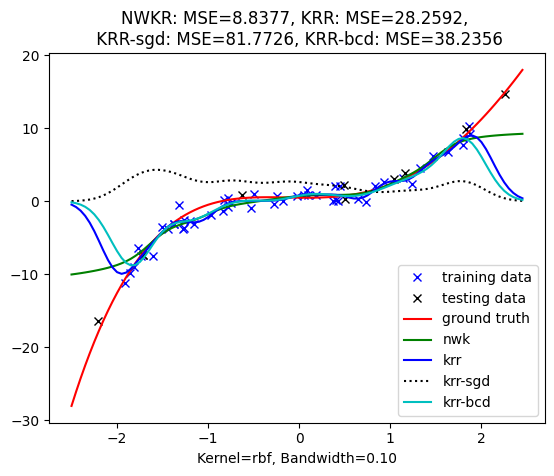

Kernel=rbf, Bandwidth=1.00 NWKR: MSE=23.0548, KRR: MSE=7.2081, 
 KRR-sgd: MSE=93.3326, KRR-bcd: MSE=16.4856


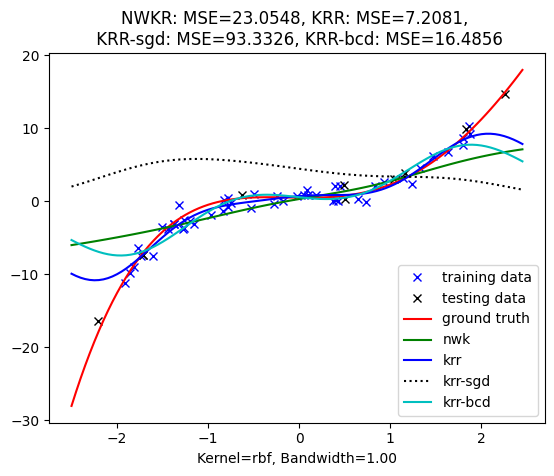

Kernel=rbf, Bandwidth=2.00 NWKR: MSE=30.9482, KRR: MSE=5.8197, 
 KRR-sgd: MSE=92.8010, KRR-bcd: MSE=12.9886


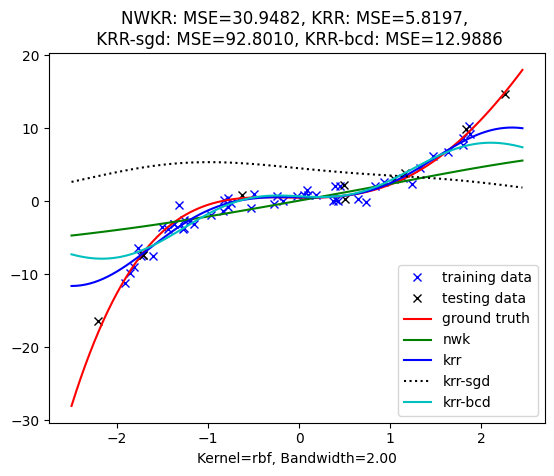

Kernel=rbf, Bandwidth=5.00 NWKR: MSE=44.0389, KRR: MSE=5.8490, 
 KRR-sgd: MSE=85.5608, KRR-bcd: MSE=22.9992


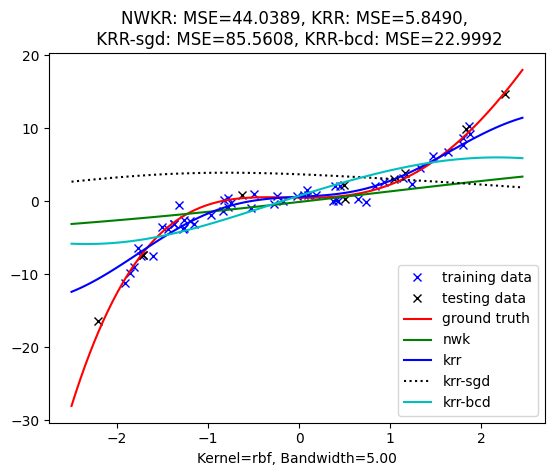

Kernel=gate, Bandwidth=0.10 NWKR: MSE=50.4698, KRR: MSE=1962.4433, 
 KRR-sgd: MSE=81.6068, KRR-bcd: MSE=58.0708


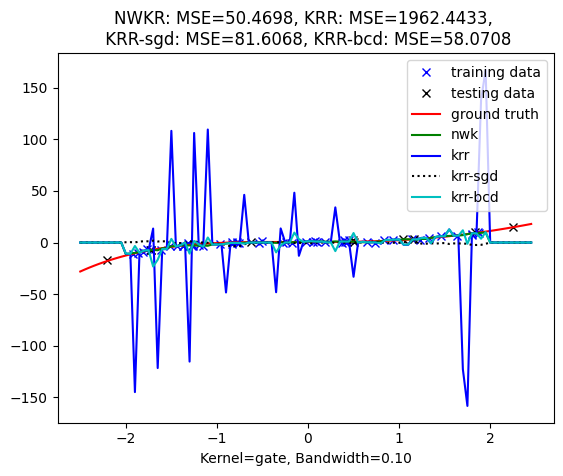

Kernel=gate, Bandwidth=1.00 NWKR: MSE=22.1923, KRR: MSE=22.4001, 
 KRR-sgd: MSE=93.6022, KRR-bcd: MSE=14.6439


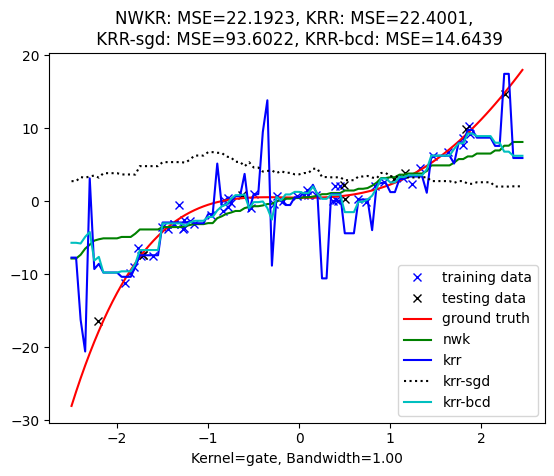

Kernel=gate, Bandwidth=2.00 NWKR: MSE=39.7643, KRR: MSE=15.8721, 
 KRR-sgd: MSE=98.3591, KRR-bcd: MSE=13.0616


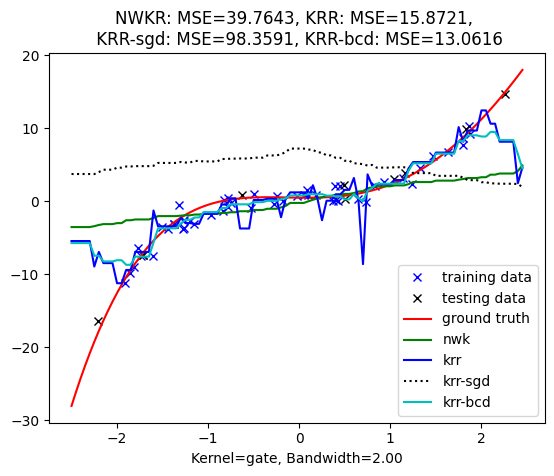

Kernel=gate, Bandwidth=5.00 NWKR: MSE=72.7131, KRR: MSE=72.7104, 
 KRR-sgd: MSE=85.9094, KRR-bcd: MSE=72.6309


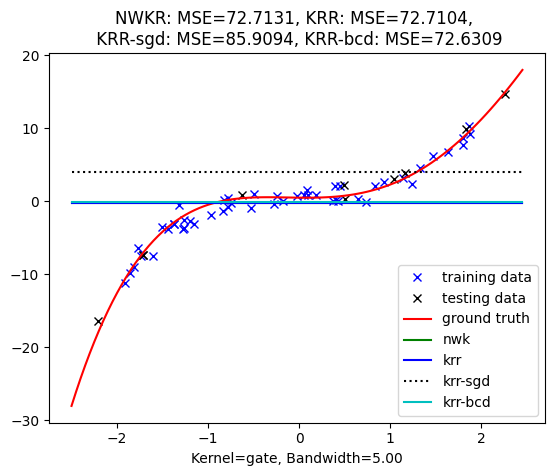

Kernel=triangle, Bandwidth=0.10 NWKR: MSE=50.4745, KRR: MSE=55.3362, 
 KRR-sgd: MSE=72.3495, KRR-bcd: MSE=70.8287


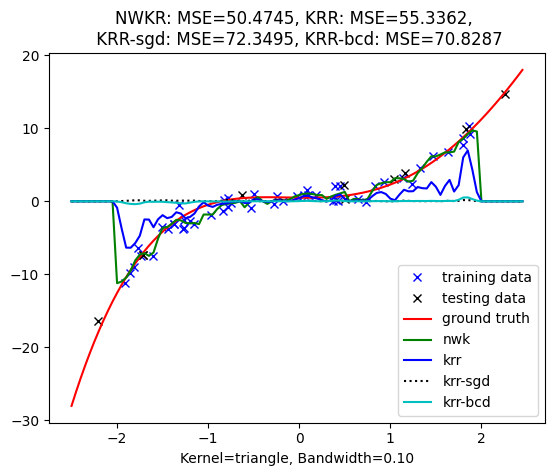

Kernel=triangle, Bandwidth=1.00 NWKR: MSE=14.2389, KRR: MSE=15.8440, 
 KRR-sgd: MSE=87.2316, KRR-bcd: MSE=21.9810


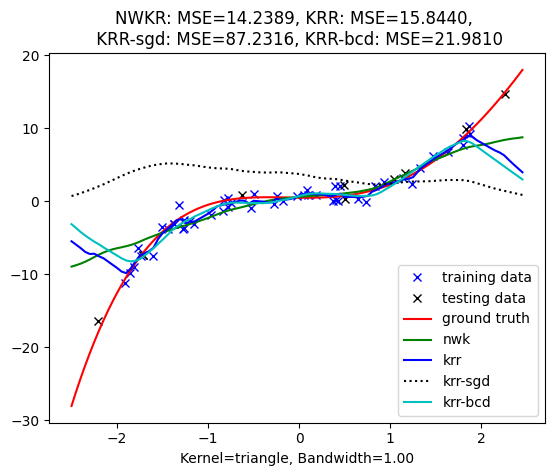

Kernel=triangle, Bandwidth=2.00 NWKR: MSE=27.2677, KRR: MSE=9.6898, 
 KRR-sgd: MSE=81.5566, KRR-bcd: MSE=11.7198


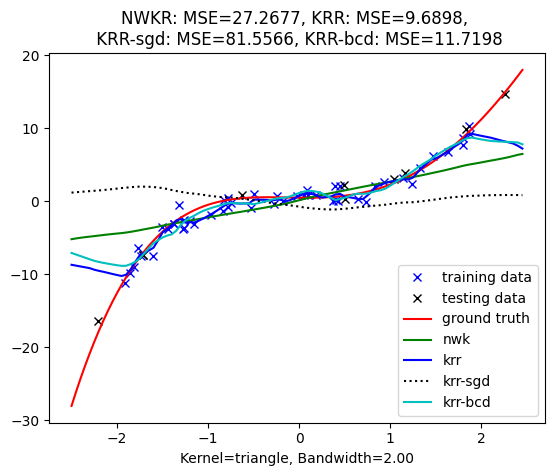

Kernel=triangle, Bandwidth=5.00 NWKR: MSE=54.7808, KRR: MSE=7.0021, 
 KRR-sgd: MSE=95.2764, KRR-bcd: MSE=11.3370


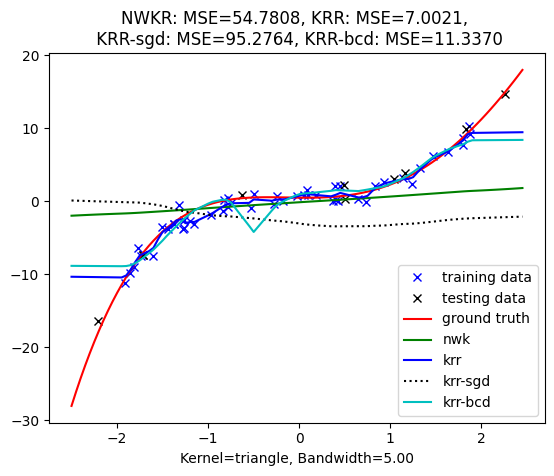

Kernel=linear, Bandwidth=0.10 NWKR: MSE=583.9222, KRR: MSE=14.7827, 
 KRR-sgd: MSE=212.5757, KRR-bcd: MSE=14.7244


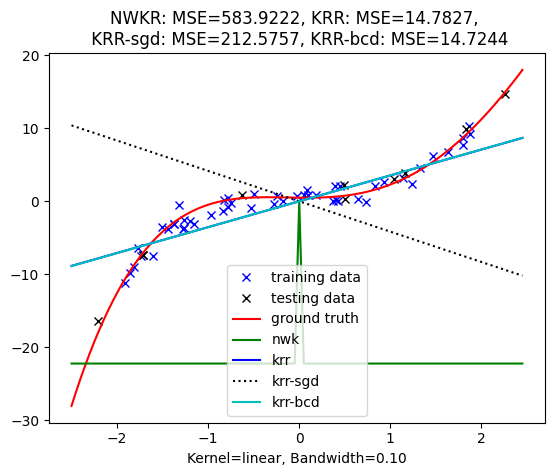

Kernel=linear, Bandwidth=1.00 NWKR: MSE=583.9222, KRR: MSE=14.7827, 
 KRR-sgd: MSE=212.5757, KRR-bcd: MSE=14.7244


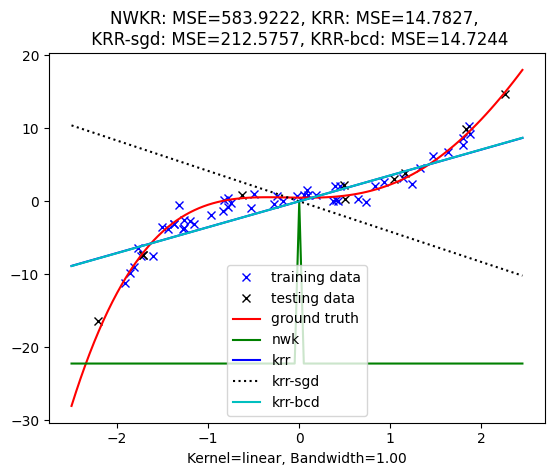

Kernel=linear, Bandwidth=2.00 NWKR: MSE=583.9222, KRR: MSE=14.7827, 
 KRR-sgd: MSE=212.5757, KRR-bcd: MSE=14.7244


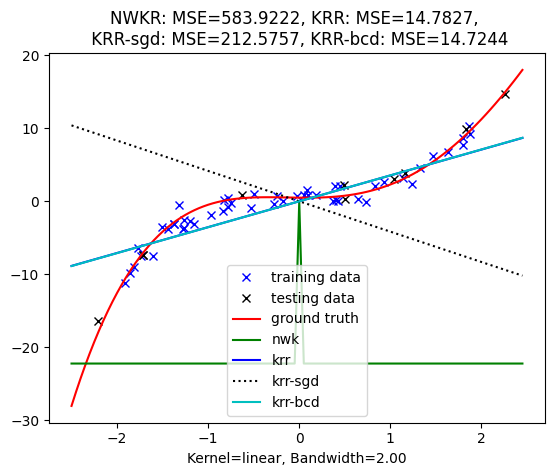

Kernel=linear, Bandwidth=5.00 NWKR: MSE=583.9222, KRR: MSE=14.7827, 
 KRR-sgd: MSE=212.5757, KRR-bcd: MSE=14.7244


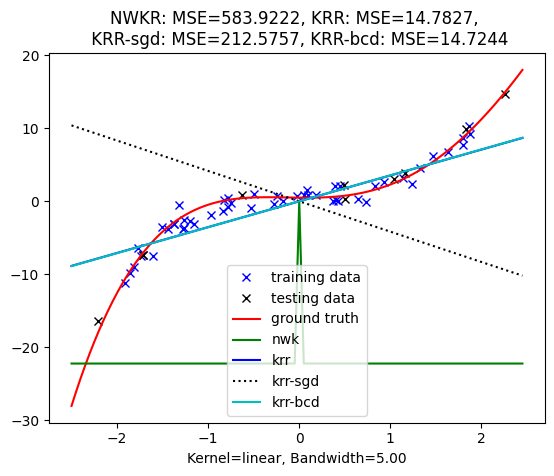

In [17]:
data = polynomial_data_simulator()
kernel_types = ['rbf', 'gate', 'triangle', 'linear']
bandwidths = [0.1, 1, 2, 5]
for k in range(len(kernel_types)):
    for i in range(len(bandwidths)):
        ker_type = kernel_types[k]
        bw = bandwidths[i]
        y_est0 = nadaraya_watson_estimator(x_test=data['test'][0],
                                            x_train=data['train'][0],
                                            y_train=data['train'][1],
                                            k_type=ker_type, h=bw)
        alpha1 = training_krr(
            x_train=data['train'][0], y_train=data['train'][1], k_type=ker_type, h=bw)
        y_est1 = testing_krr(
            x_test=data['test'][0], x_train=data['train'][0], alpha=alpha1, k_type=ker_type, h=bw)
        alpha2 = training_krr_sgd(
            x_train=data['train'][0], y_train=data['train'][1], k_type=ker_type, h=bw)
        y_est2 = testing_krr(
            x_test=data['test'][0], x_train=data['train'][0], alpha=alpha2, k_type=ker_type, h=bw)
        alpha3 = training_krr_bcd(
            x_train=data['train'][0], y_train=data['train'][1], k_type=ker_type, h=bw)
        y_est3 = testing_krr(
            x_test=data['test'][0], x_train=data['train'][0], alpha=alpha3, k_type=ker_type, h=bw)

        mse0 = mse(data['test'][1], y_est0)
        mse1 = mse(data['test'][1], y_est1)
        mse2 = mse(data['test'][1], y_est2)
        mse3 = mse(data['test'][1], y_est3)

        setting = 'Kernel={}, Bandwidth={:.2f}'.format(
            ker_type, bw)
        result = 'NWKR: MSE={:.4f}, KRR: MSE={:.4f}, \n KRR-sgd: MSE={:.4f}, KRR-bcd: MSE={:.4f}'.format(
            mse0, mse1, mse2, mse3)
        print(setting + ' ' + result)

        plt.figure()
        visualization_points(
            x=data['train'][0], y=data['train'][1][:, 0], point_type='bx', label='training data')
        visualization_points(
            x=data['test'][0], y=data['test'][1][:, 0], point_type='kx', label='testing data')
        visualization_curves(
            weights=data['real'], label='ground truth', curve_type='r-')
        visualization_kernel_curves(alpha=data['train'][1], x_train=data['train'][0],
                                    k_type=ker_type, h=bw, label='nwk', curve_type='g-', normalize=True)
        visualization_kernel_curves(alpha=alpha1, x_train=data['train'][0],
                                    k_type=ker_type, h=bw, label='krr', curve_type='b-')
        visualization_kernel_curves(alpha=alpha2, x_train=data['train'][0],
                                    k_type=ker_type, h=bw, label='krr-sgd', curve_type='k:')
        visualization_kernel_curves(alpha=alpha3, x_train=data['train'][0],
                                    k_type=ker_type, h=bw, label='krr-bcd', curve_type='c-')
        plt.title(result)
        plt.xlabel(setting)
        plt.legend()
        plt.show()
